## Business Problem:

Cookie Cats is a popular mobile puzzle game. In this game, players complete different levels and occasionally encounter gates that force them to wait before they can progress or make an in-game purchase. The current version of the game has the first gate at level 30. The product team wants to test moving this gate to level 40 to see if it improves player retention.

As a product data scientist, our goal is to analyze the A/B test results and help the team decide whether to keep the gate at level 30 or move it to level 40.


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

## Set random seed for reproducibility

In [2]:
SEED = 123
np.random.seed(SEED)

### Disable warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [18]:
df = pd.read_csv('data/cookie_cats.csv')

## Step 1 - Understand the Business Problem

In [19]:
# Display the first five rows
print("First few rows of the dataset:")
print(df.head())

# Basic statistics
print("\nDataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

First few rows of the dataset:
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None

Missing Values:
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7

In [20]:
# Get basic stats about the versions
version_stats = df.groupby('version').agg({
    'userid': 'count',
    'retention_1': 'mean',
    'retention_7': 'mean',
    'sum_gamerounds': 'mean'
}).round(4)

print("\nBasic Statistics by Version:")
print(version_stats)


Basic Statistics by Version:
         userid  retention_1  retention_7  sum_gamerounds
version                                                  
gate_30   44700       0.4482       0.1902         52.4563
gate_40   45489       0.4423       0.1820         51.2988


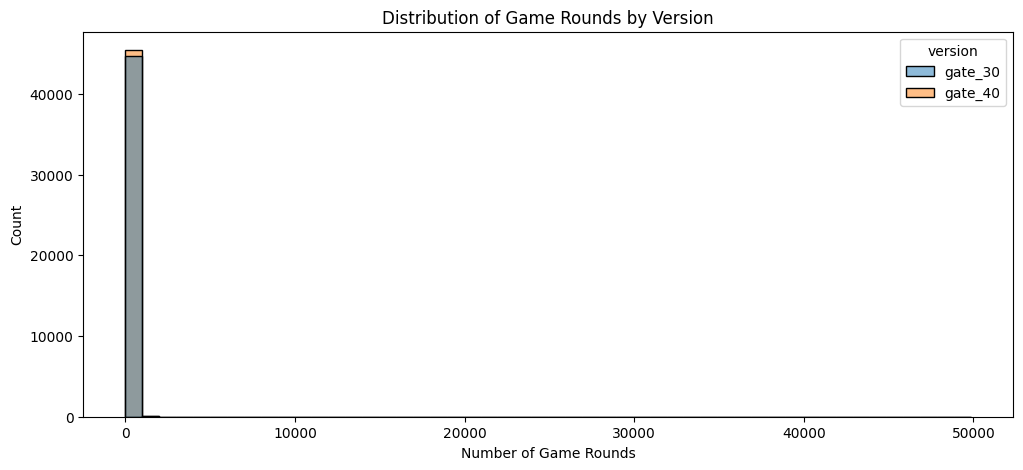

In [21]:
# Visualize game rounds distribution
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='sum_gamerounds', hue='version', bins=50)
plt.title('Distribution of Game Rounds by Version')
plt.xlabel('Number of Game Rounds')
plt.ylabel('Count')
plt.show()

- There's a huge spike at or near 0 game rounds
- The rest of the distribution is barely visible
- This suggests our data is highly skewed (not normally distributed)
- Most players are clustered in the low numbers
- A few players might have very high numbers (up to 50,000 rounds)
- This extreme range makes the visualization hard to interpret

Let's use log scale to visualise the distribution better:

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

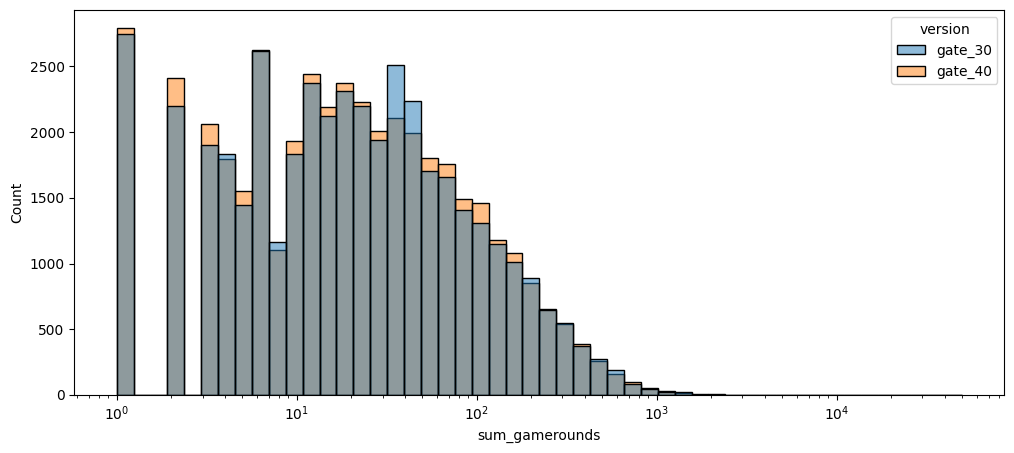

In [23]:
plt.figure(figsize=(12, 5))
sns.histplot(data=df, x='sum_gamerounds', hue='version', bins=50, log_scale=True)

- Highest peaks are around 10⁰ to 10¹ (1-10 rounds): Most players played very few rounds
- Middle range is around 10¹ to 10² (10-100 rounds): Moderate number of players
- Long tail extends to 10⁴ (10,000 rounds): Very few highly engaged players
- Strong right-skewed distribution (long tail to the right)
- Most players concentrate in the lower game rounds

- gate_30 (blue) and gate_40 (orange) follow similar pattern
- Both versions show similar decay in player count as rounds increase

## Step 2 - State the Hypothesis


For Day-1 Retention:
- Ho: The Day-1 retention rates between gate_30 and gate_40 are the same
- Ha: The Day-1 retention rates between gate_30 and gate_40 are different

For Day-7 Retention:
- Ho: The Day-7 retention rates between gate_30 and gate_40 are the same
- Ha: The Day-7 retention rates between gate_30 and gate_40 are different

For Game Rounds:
- Ho: The average number of game rounds between gate_30 and gate_40 are the same
- Ha: The average number of game rounds between gate_30 and gate_40 are different


In [22]:
# Experiment parameters
alpha = 0.05  # Significance level
power = 0.80  # Statistical power
mde = 0.10    # Minimum detectable effect


# Number of tests/metrics
n_tests = 3  # Day 1 retention, Day 7 retention, game rounds

# Bonferroni corrected alpha
alpha_bonferroni = alpha / n_tests
print(f"Original alpha: {alpha}")
print(f"Bonferroni corrected alpha: {alpha_bonferroni}")


# Current retention rates
retention_1_rate = df['retention_1'].mean()
retention_7_rate = df['retention_7'].mean()

Original alpha: 0.05
Bonferroni corrected alpha: 0.016666666666666666


## Step 3 - Design the Experiment


In [10]:
# Calculate effect size and required sample size
def calculate_sample_size(p1, mde):
    p2 = p1 * (1 + mde)
    cohen_h = sm.stats.proportion_effectsize(p1, p2)
    n = tt_ind_solve_power(effect_size=cohen_h, power=power, alpha=alpha)
    return int(round(n, -2))  # Round to nearest hundred

#p1: This is the baseline conversion rate or retention rate (the current performance metric)
#p2: This calculates the expected conversion/retention rate after the change
#mde: Minimum Detectable Effect - the smallest change in the metric that you want to be able to detect with statistical significance

# Calculate for both retention metrics
n_day1 = calculate_sample_size(df[df['version'] == 'gate_30']['retention_1'].mean(), mde)
n_day7 = calculate_sample_size(df[df['version'] == 'gate_30']['retention_7'].mean(), mde)

print(f"Required sample size per group (Day-1): {n_day1}")
print(f"Required sample size per group (Day-7): {n_day7}")


Required sample size per group (Day-1): 1900
Required sample size per group (Day-7): 6900


<Figure size 1000x600 with 0 Axes>

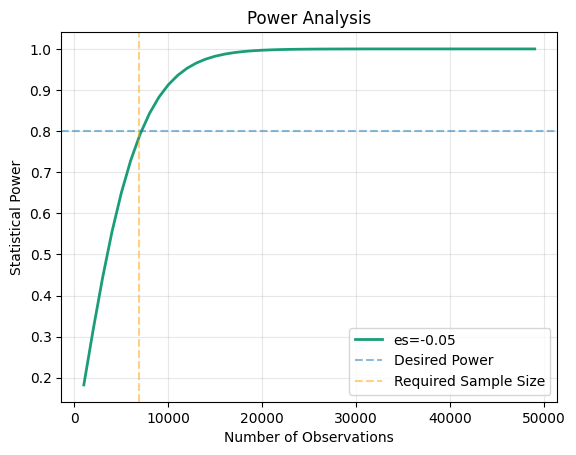

In [11]:
# Power Analysis Plot
plt.figure(figsize=(10, 6))
effect_size = sm.stats.proportion_effectsize(retention_7_rate, retention_7_rate * (1 + mde))
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=np.arange(1000, 50000, 1000), effect_size=[effect_size])
plt.axhline(0.8, linestyle='--', label='Desired Power', alpha=0.5)
plt.axvline(max(n_day1, n_day7), linestyle='--', color='orange', label='Required Sample Size', alpha=0.5)
plt.title('Power Analysis')
plt.ylabel('Statistical Power')
plt.grid(alpha=0.3)
plt.legend()
plt.show()


## Step 4 - Analyze the Results


In [12]:
# Calculate metrics for each version
metrics = df.groupby('version').agg({
    'userid': 'count',
    'retention_1': ['count', 'mean'],
    'retention_7': ['count', 'mean'],
    'sum_gamerounds': ['mean', 'std']
}).round(4)

print("\nDetailed Metrics by Version:")
print(metrics)


Detailed Metrics by Version:
        userid retention_1         retention_7         sum_gamerounds  \
         count       count    mean       count    mean           mean   
version                                                                 
gate_30  44700       44700  0.4482       44700  0.1902        52.4563   
gate_40  45489       45489  0.4423       45489  0.1820        51.2988   

                   
              std  
version            
gate_30  256.7164  
gate_40  103.2944  


## Step 5 - Statistical Testing


In [16]:
# Function for chi-square test
def run_chi_square_test(df, metric):
    # Create contingency table
    contingency = pd.crosstab(df['version'], df[metric])
    # Run chi-square test
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    return chi2, p_value

In [17]:
# Chi-square test for Day 1 retention
chi2_1day, p_value_1day = run_chi_square_test(df, 'retention_1')

# Chi-square test for Day 7 retention
chi2_7day, p_value_7day = run_chi_square_test(df, 'retention_7')

In [18]:
# T-test for game rounds
rounds_control = df[df['version'] == 'gate_30']['sum_gamerounds']
rounds_treatment = df[df['version'] == 'gate_40']['sum_gamerounds']
t_stat, p_value_rounds = stats.ttest_ind(rounds_control, rounds_treatment)


In [19]:
print("\nStatistical Test Results:")
print("\n1. Day 1 Retention Chi-square Test:")
print(f"Chi-square statistic: {chi2_1day:.4f}")
print(f"p-value: {p_value_1day:.4f}")

print("\n2. Day 7 Retention Chi-square Test:")
print(f"Chi-square statistic: {chi2_7day:.4f}")
print(f"p-value: {p_value_7day:.4f}")

print("\n3. Game Rounds T-test:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value_rounds:.4f}")




Statistical Test Results:

1. Day 1 Retention Chi-square Test:
Chi-square statistic: 3.1591
p-value: 0.0755

2. Day 7 Retention Chi-square Test:
Chi-square statistic: 9.9591
p-value: 0.0016

3. Game Rounds T-test:
t-statistic: 0.8910
p-value: 0.3729


## Step 6 - Effect Size Analysis


In [20]:
# Calculate relative differences
def calculate_relative_difference(df, metric_col):
    rates = df.groupby('version')[metric_col].mean()
    rel_diff = ((rates['gate_40'] - rates['gate_30']) / rates['gate_30'] * 100)
    return rel_diff


In [21]:
# Calculate effect sizes
day1_effect = calculate_relative_difference(df, 'retention_1')
day7_effect = calculate_relative_difference(df, 'retention_7')
rounds_effect = calculate_relative_difference(df, 'sum_gamerounds')


In [22]:
print("\nEffect Size Analysis:")
print(f"Day 1 Retention Relative Difference: {day1_effect:.2f}%")
print(f"Day 7 Retention Relative Difference: {day7_effect:.2f}%")
print(f"Game Rounds Relative Difference: {rounds_effect:.2f}%")




Effect Size Analysis:
Day 1 Retention Relative Difference: -1.32%
Day 7 Retention Relative Difference: -4.31%
Game Rounds Relative Difference: -2.21%


## Step 7 - Decision and Recommendation


Based on the analysis:

1. Statistical Significance:
- Day 1 Retention: Not statistically significant (p = 0.0755)
- Day 7 Retention: Statistically significant (p = 0.0016)
- Game Rounds: Not statistically significant (p = 0.3729)

2. Effect Sizes:
- Day 1 Retention: -1.32% (negative impact)
- Day 7 Retention: -4.31% (negative impact)
- Game Rounds: -2.21% (negative impact)

Recommendation:
Keep the gate at level 30 (control version) because:
1. Moving the gate to level 40 shows a significant negative impact on 7-day retention
2. All metrics show negative trends, though only 7-day retention is statistically significant
3. The 4.31% decrease in 7-day retention is both statistically and practically significant
4. There are no offsetting positive effects in other metrics to justify the change
